In [3]:
import warnings
warnings.simplefilter('ignore')

In [34]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
from fast_ml.feature_selection import get_constant_features
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.cluster import DBSCAN
from itertools import product

%matplotlib inline

In [5]:
df = pd.read_csv('Mall_Customers.csv')
df

CustomerID   Genre  Age  Annual Income (k$)  Spending Score (1-100)
0             1    Male   19                  15                      39
1             2    Male   21                  15                      81
2             3  Female   20                  16                       6
3             4  Female   23                  16                      77
4             5  Female   31                  17                      40
..          ...     ...  ...                 ...                     ...
195         196  Female   35                 120                      79
196         197  Female   45                 126                      28
197         198    Male   32                 126                      74
198         199    Male   32                 137                      18
199         200    Male   30                 137                      83

[200 rows x 5 columns]

In [6]:
df.rename(columns={'Annual Income (k$)':'Annual Income'},inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income           200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [8]:
df.describe()

CustomerID         Age  Annual Income  Spending Score (1-100)
count  200.000000  200.000000     200.000000              200.000000
mean   100.500000   38.850000      60.560000               50.200000
std     57.879185   13.969007      26.264721               25.823522
min      1.000000   18.000000      15.000000                1.000000
25%     50.750000   28.750000      41.500000               34.750000
50%    100.500000   36.000000      61.500000               50.000000
75%    150.250000   49.000000      78.000000               73.000000
max    200.000000   70.000000     137.000000               99.000000

##### Should not one-hot encode the gender column

link - https://www.ibm.com/support/pages/clustering-binary-data-k-means-should-be-avoided

### Generating the Profile Report

In [9]:
profile = ProfileReport(df)
profile.to_file('profile.html')

Export report to file: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 148.85it/s]


### Points from Profile Report - 

1. No null values
2. Columns are not normally distributed
3. Ages 20-40 have high spending scores compared to elderly people with more age. 
4. People having spending score 40-60 have an annual income of 40k-60k (dollars).

### Duplicate Records

In [10]:
df.duplicated().sum() # No duplicate rows

0

In [11]:
df.T.duplicated().sum()

0

### Constant and Quasi-constant features

In [12]:
get_constant_features(df)

Empty DataFrame
Columns: [Desc, Var, Value, Perc]
Index: []

### EDA

In [13]:
males_age = df[df['Genre']=='Male']['Age'] # subset with males age
females_age = df[df['Genre']=='Female']['Age'] # subset with females age

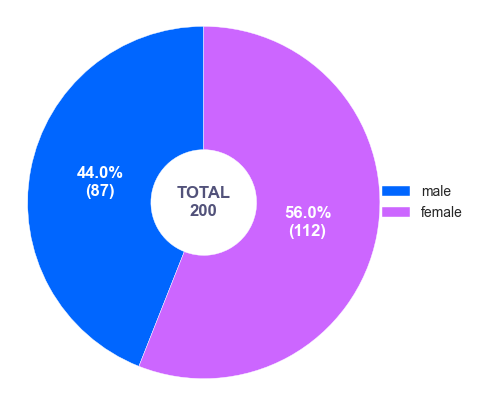

In [14]:
def labeler(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

sizes = [males_age.count(),females_age.count()] # wedge sizes

fig0, ax1 = plt.subplots(figsize=(5,5))
wedges, texts, autotexts = ax1.pie(sizes,
                                   autopct=lambda pct: labeler(pct, sizes),
                                   radius=1,
                                   colors=['#0066ff','#cc66ff'],
                                   startangle=90,
                                   textprops=dict(color="w"),
                                   wedgeprops=dict(width=0.7, edgecolor='w'))

ax1.legend(wedges, ['male','female'],
           loc='center right',
           bbox_to_anchor=(0.7, 0, 0.5, 1))

plt.text(0,0, 'TOTAL\n{}'.format(df['Age'].count()),
         weight='bold', size=12, color='#52527a',
         ha='center', va='center')

plt.setp(autotexts, size=12, weight='bold')
ax1.axis('equal')  # Equal aspect ratio
plt.show()

#### Number of female customers are more than male.

### Outliers

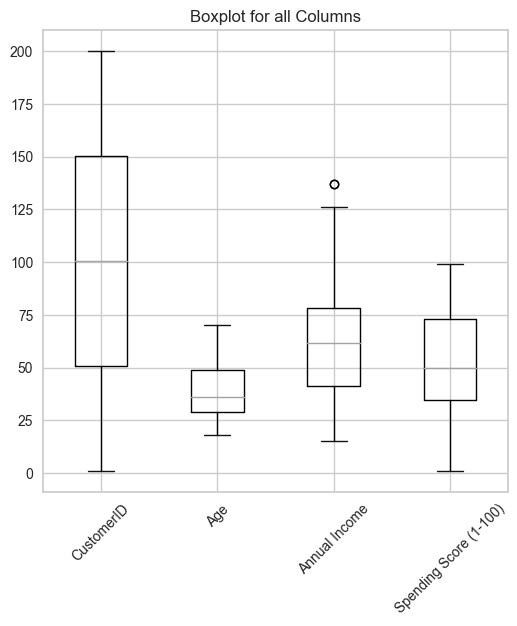

In [15]:
df.select_dtypes(include='number').boxplot(figsize=(6, 6))
plt.title("Boxplot for all Columns")
plt.xticks(rotation=45)  # Rotating x-axis labels for better readability
plt.show()

#### Only Annual Income has the outliers

<Axes: xlabel='Annual Income', ylabel='Density'>

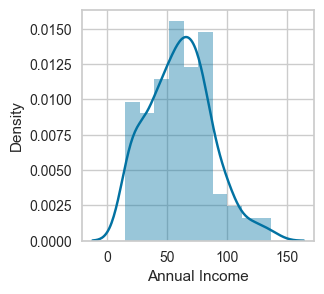

In [16]:
plt.figure(figsize=(3,3))
sns.distplot(df['Annual Income'])

In [17]:
# IQR to remove outliers

def remove_outlier(column):
    percent_75 = df[column].quantile(0.75)
    percent_25 = df[column].quantile(0.25)
    
    iqr = percent_75 - percent_25
    
    upper_limit = percent_75 + 1.5*iqr
    lower_limit = percent_25 - 1.5*iqr
    
    #capping outliers
    df[column] = np.where(
    df[column] > upper_limit,upper_limit,
        np.where(df[column] < lower_limit,lower_limit,df[column]))
    
    return column

remove_outlier('Annual Income')

'Annual Income'

<Axes: >

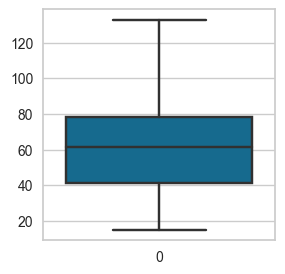

In [18]:
plt.figure(figsize=(3,3))
sns.boxplot(df['Annual Income'])

### Finding clusters using K-means

In [19]:
df.columns

Index(['CustomerID', 'Genre', 'Age', 'Annual Income',
       'Spending Score (1-100)'],
      dtype='object')

In [20]:
# Leaving the CustomerID and Genre, rest of the columns will be taken for finding optimal clusters
# ['Age', 'Annual Income','Spending Score (1-100)']

data_for_clusters = df.iloc[:,2:].values

##### To choose the number of clusters

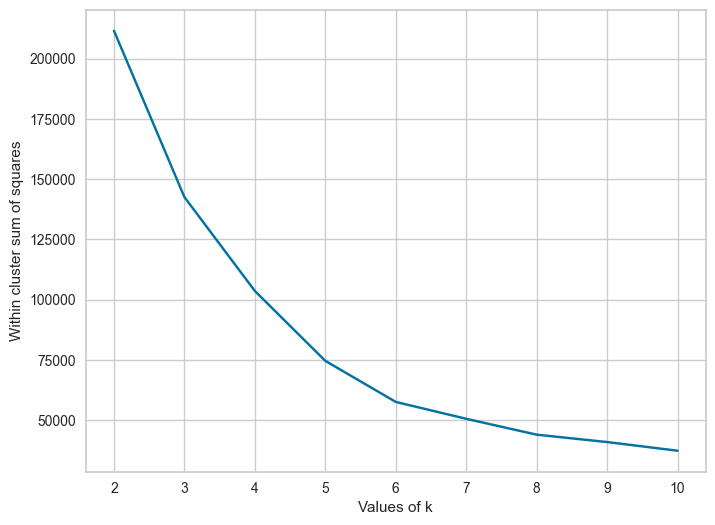

In [21]:
wcss = [] #within cluster sum of square

for i in range(2,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans.fit(data_for_clusters)
    wcss.append(kmeans.inertia_)
    
plt.figure(figsize=(8,6))
plt.plot(range(2,11), wcss)
plt.xlabel("Values of k")
plt.ylabel("Within cluster sum of squares")
plt.show()

#### From the Elbow-graph, clusters=6

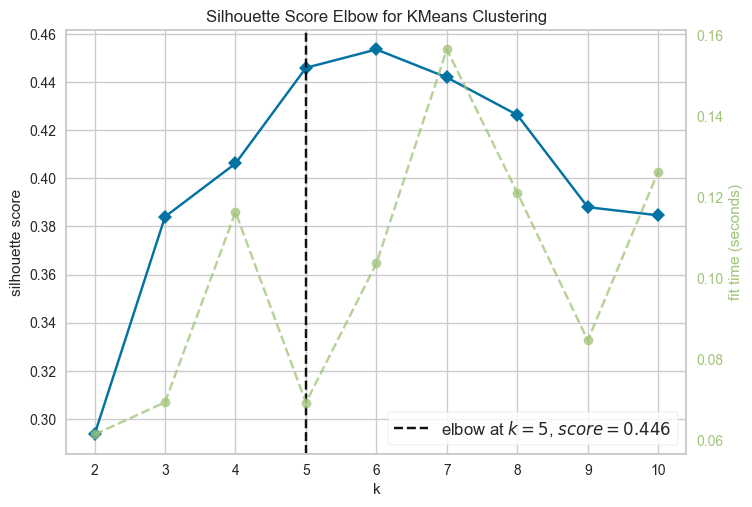

In [22]:
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2,11), metric='silhouette')

visualizer.fit(data_for_clusters)
visualizer.show()
plt.show()

#### According to the graph, at k=6, silhouette score is the highest. But graph still choosing k=5.

### Checking the silhouette score (to find if k=6 is optimal)

In [23]:
cluster = KMeans(n_clusters=6,random_state=42)
clusters = cluster.fit_predict(data_for_clusters)

In [24]:
clusters

array([3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4,
       3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 0, 4, 3, 2,
       3, 4, 0, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2,
       0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2,
       2, 0, 0, 2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0,
       0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 1, 2, 1, 5, 1, 5, 1, 5, 1,
       2, 1, 5, 1, 5, 1, 5, 1, 5, 1, 2, 1, 5, 1, 5, 1, 5, 1, 5, 1, 5, 1,
       5, 1, 5, 1, 5, 1, 5, 1, 5, 1, 5, 1, 5, 1, 5, 1, 5, 1, 5, 1, 5, 1,
       5, 1, 5, 1, 5, 1, 5, 1, 5, 1, 5, 1, 5, 1, 5, 1, 5, 1, 5, 1, 5, 1,
       5, 1])

In [25]:
print(silhouette_score(data_for_clusters, clusters)) # good model

0.4535010494796727


#### Compare with all k values and graph

In [26]:
for i in range(2,11):
    clust = KMeans(n_clusters=i, random_state=23)
    clusters = clust.fit_predict(data_for_clusters)
    print("For ", i, " clusters, score is = ", silhouette_score(data_for_clusters, clusters))

For  2  clusters, score is =  0.2935610473840494
For  3  clusters, score is =  0.3840264152843733
For  4  clusters, score is =  0.40614375021198673
For  5  clusters, score is =  0.44531970653868974
For  6  clusters, score is =  0.4534885435878979
For  7  clusters, score is =  0.43898291419332836
For  8  clusters, score is =  0.42630734630776673
For  9  clusters, score is =  0.4097241471090803
For  10  clusters, score is =  0.38104080455841405


#### For  6  clusters, score is =  0.4534885435878979

#### Not very good but best of all and semi-well separated clusters with k=6

#### Silhouette score analysis

For n_clusters = 2 The average silhouette_score is : 0.2935610473840494
For n_clusters = 3 The average silhouette_score is : 0.3840264152843733
For n_clusters = 4 The average silhouette_score is : 0.40614375021198673
For n_clusters = 5 The average silhouette_score is : 0.4413302533414975
For n_clusters = 6 The average silhouette_score is : 0.4534885435878979
For n_clusters = 7 The average silhouette_score is : 0.4418866283911202


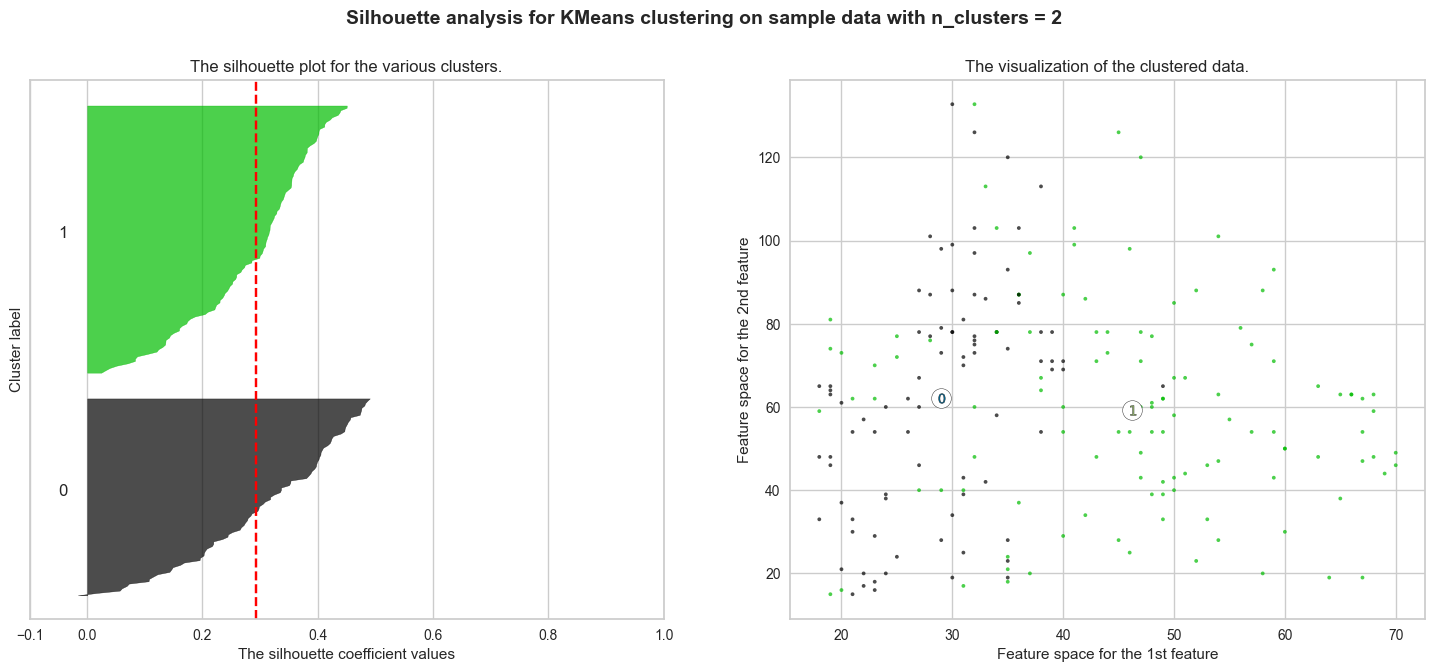

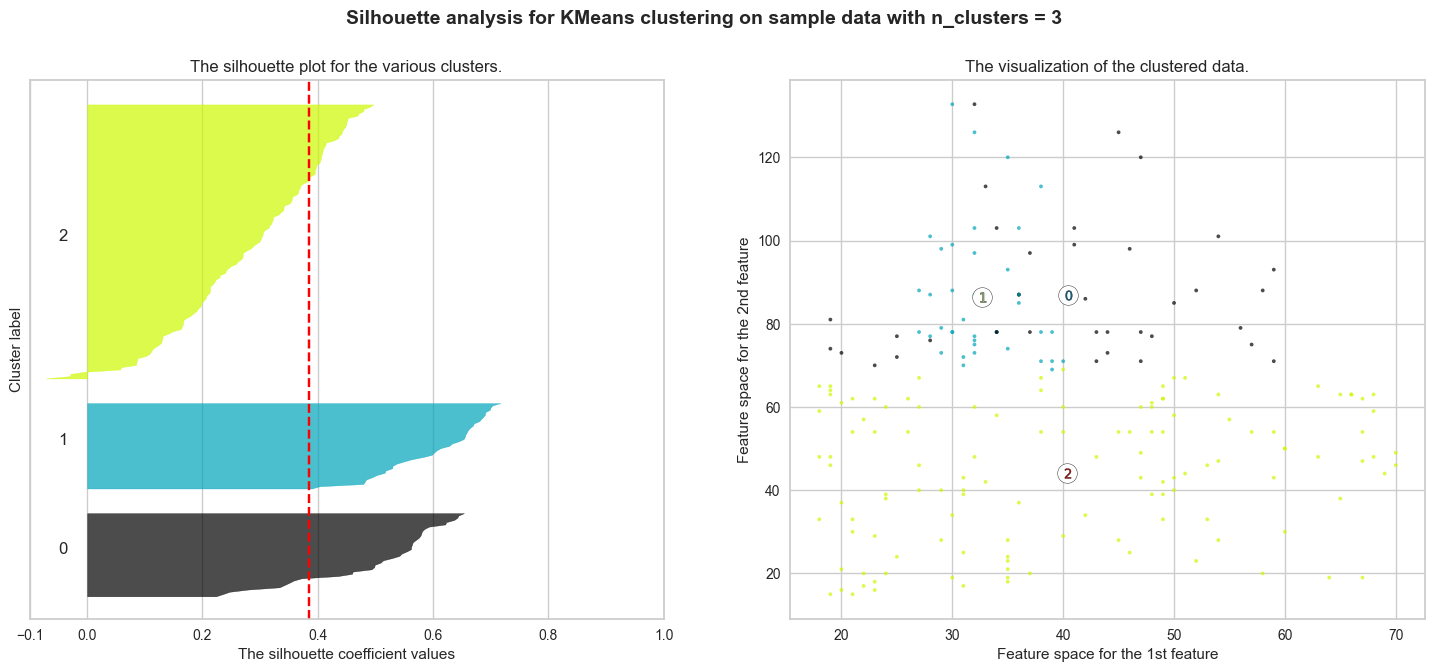

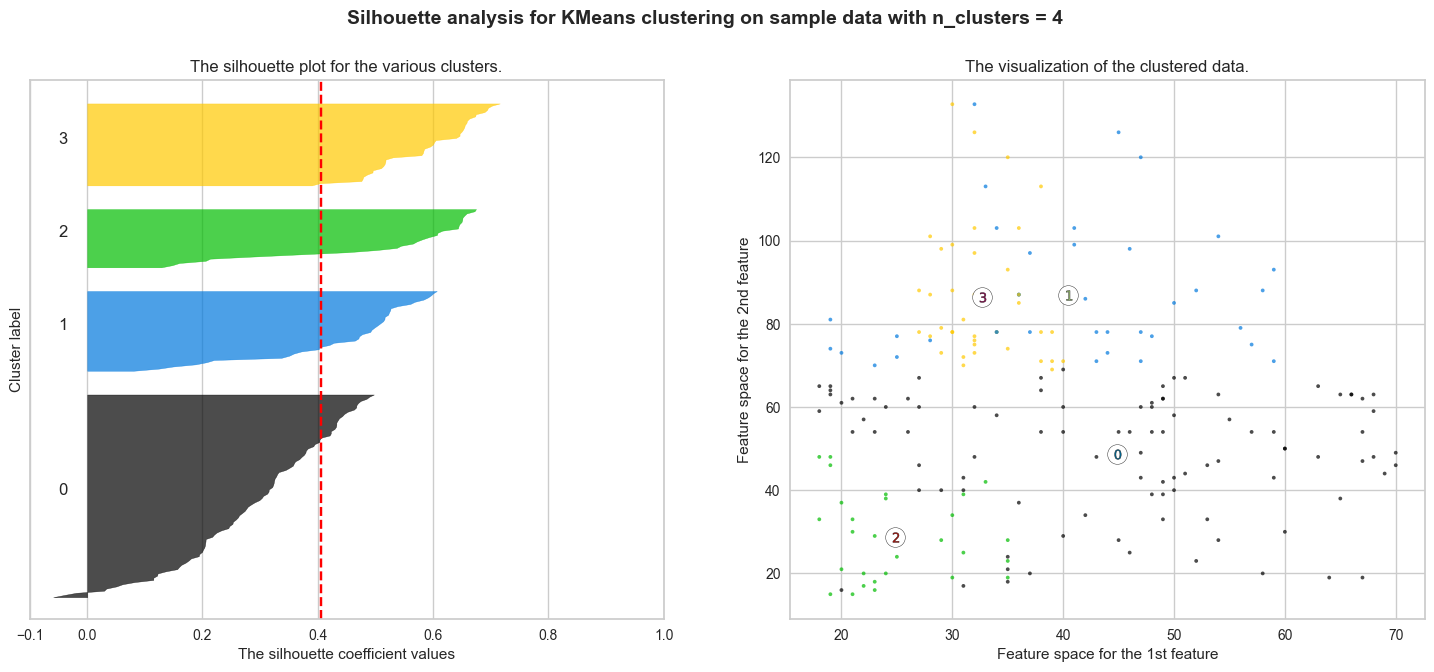

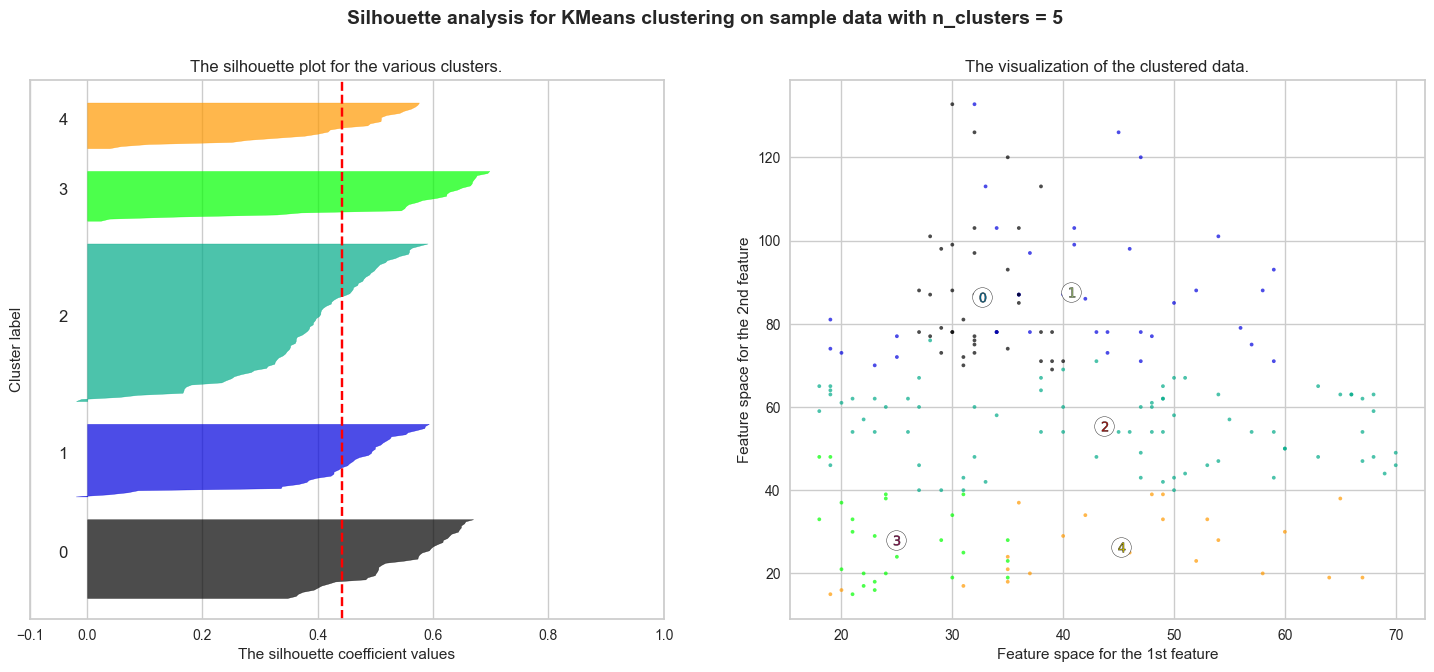

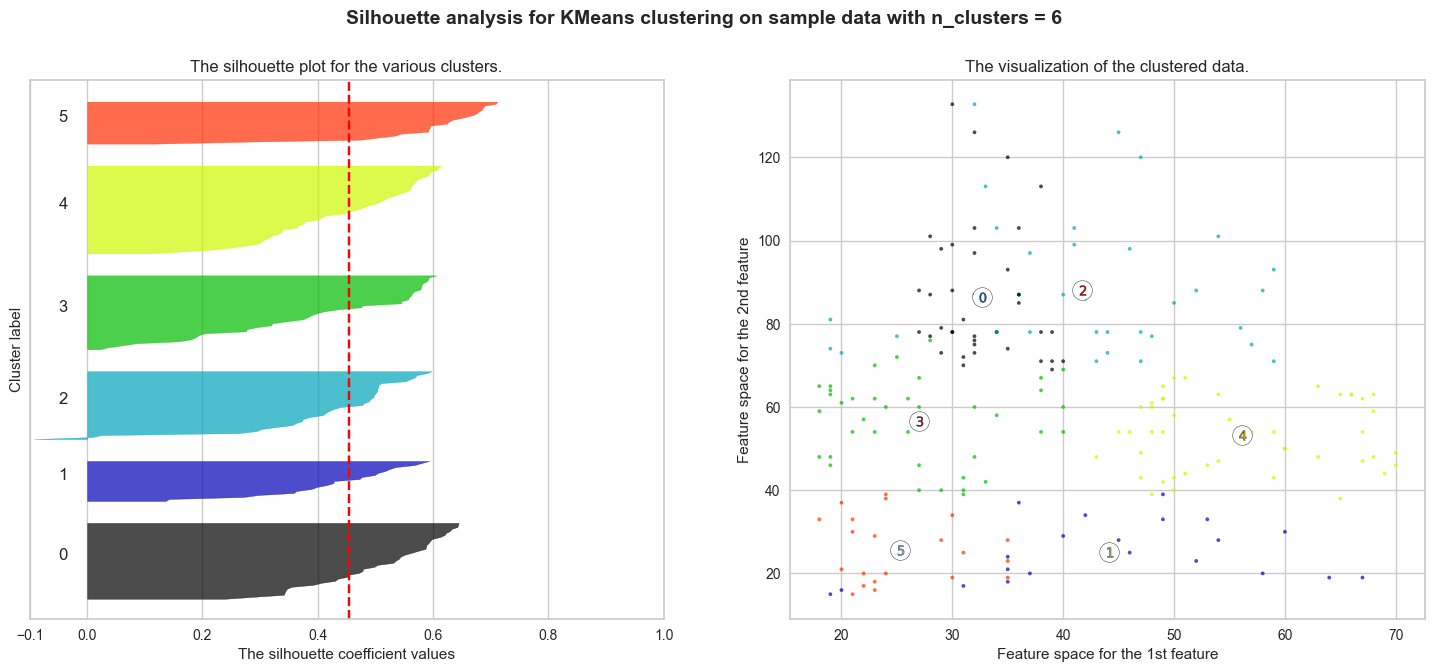

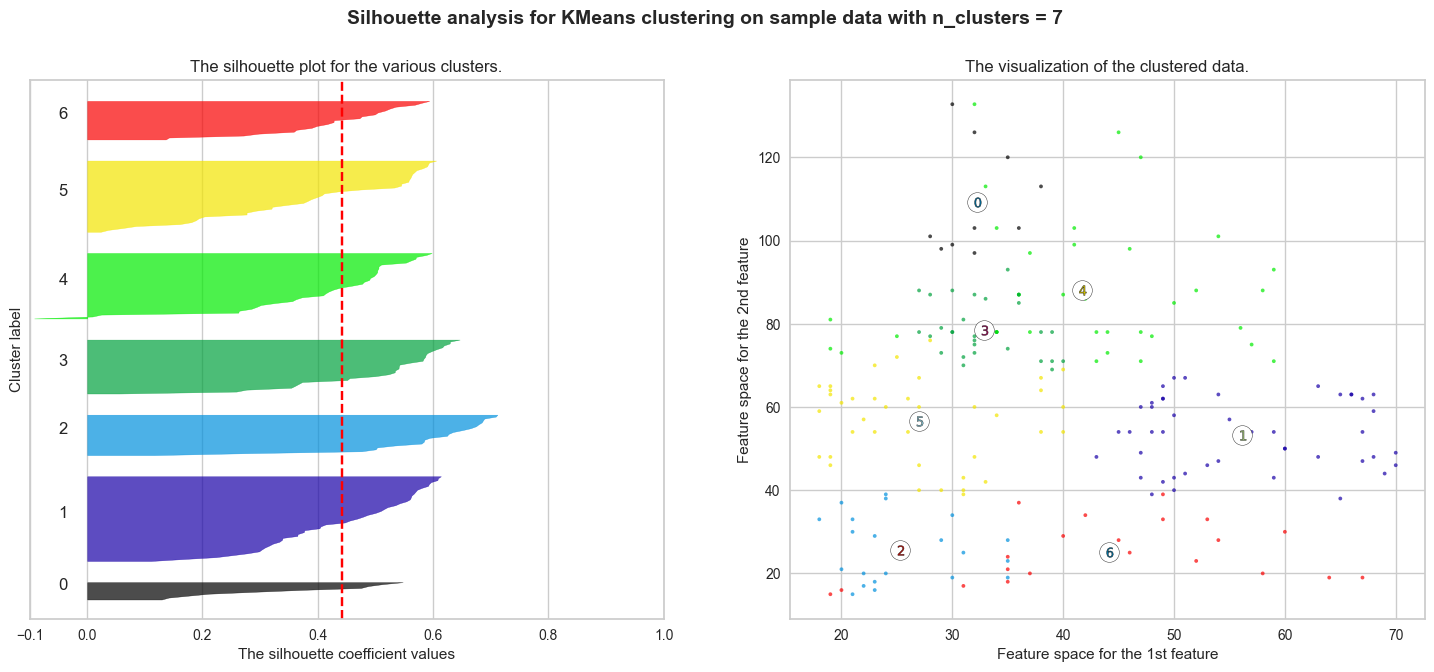

In [29]:
X = data_for_clusters
range_n_clusters = range(2,8)

range_n_clusters = range(2,8)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

### Training the Kmeans

In [30]:
kmeans = KMeans(n_clusters=6,random_state=42,init='k-means++')

# returning a label for each data point based on their cluster
y = kmeans.fit_predict(data_for_clusters)

In [31]:
data_for_clusters

array([[ 19.  ,  15.  ,  39.  ],
       [ 21.  ,  15.  ,  81.  ],
       [ 20.  ,  16.  ,   6.  ],
       [ 23.  ,  16.  ,  77.  ],
       [ 31.  ,  17.  ,  40.  ],
       [ 22.  ,  17.  ,  76.  ],
       [ 35.  ,  18.  ,   6.  ],
       [ 23.  ,  18.  ,  94.  ],
       [ 64.  ,  19.  ,   3.  ],
       [ 30.  ,  19.  ,  72.  ],
       [ 67.  ,  19.  ,  14.  ],
       [ 35.  ,  19.  ,  99.  ],
       [ 58.  ,  20.  ,  15.  ],
       [ 24.  ,  20.  ,  77.  ],
       [ 37.  ,  20.  ,  13.  ],
       [ 22.  ,  20.  ,  79.  ],
       [ 35.  ,  21.  ,  35.  ],
       [ 20.  ,  21.  ,  66.  ],
       [ 52.  ,  23.  ,  29.  ],
       [ 35.  ,  23.  ,  98.  ],
       [ 35.  ,  24.  ,  35.  ],
       [ 25.  ,  24.  ,  73.  ],
       [ 46.  ,  25.  ,   5.  ],
       [ 31.  ,  25.  ,  73.  ],
       [ 54.  ,  28.  ,  14.  ],
       [ 29.  ,  28.  ,  82.  ],
       [ 45.  ,  28.  ,  32.  ],
       [ 35.  ,  28.  ,  61.  ],
       [ 40.  ,  29.  ,  31.  ],
       [ 23.  ,  29.  ,  87.  ],
       [ 6

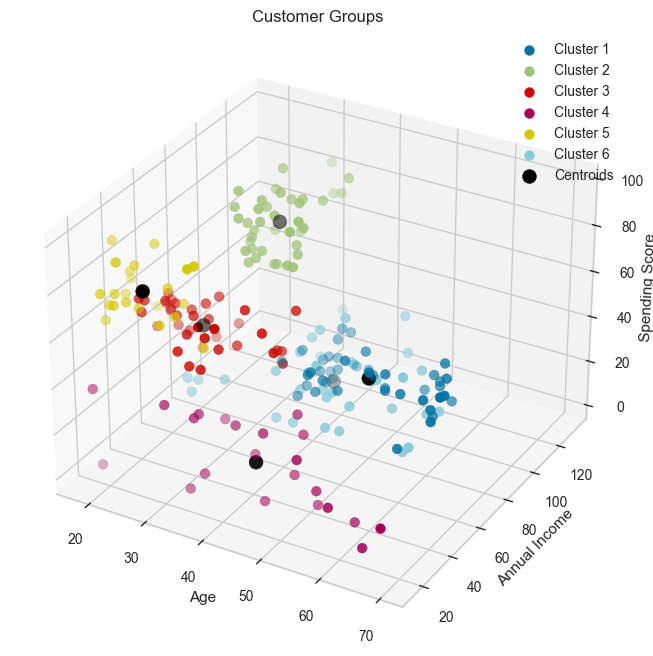

In [32]:
X = data_for_clusters
Y = y
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')


for cluster_num in range(6):
    ax.scatter(X[Y == cluster_num, 0], X[Y == cluster_num, 1], X[Y == cluster_num, 2],
               s=50, label=f'Cluster {cluster_num + 1}')

# centroids
ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2],
           s=100, c='black', label='Centroids')

ax.set_title('Customer Groups')
ax.set_xlabel('Age')
ax.set_ylabel('Annual Income')
ax.set_zlabel('Spending Score')
ax.legend()
plt.show()

In [33]:
X = data_for_clusters
Y = y

fig = go.Figure()

for cluster_num in range(6):
    fig.add_trace(go.Scatter3d(x=X[Y == cluster_num, 0], y=X[Y == cluster_num, 1], z=X[Y == cluster_num, 2],
                               mode='markers', marker=dict(size=8),
                               name=f'Cluster {cluster_num + 1}'))

# Adding centroid
fig.add_trace(go.Scatter3d(x=kmeans.cluster_centers_[:, 0], y=kmeans.cluster_centers_[:, 1],
                           z=kmeans.cluster_centers_[:, 2], mode='markers',
                           marker=dict(size=12, color='black'),
                           name='Centroids'))

fig.update_layout(title='Clustered Customers',
                  scene=dict(xaxis_title='Age', yaxis_title='Annual Income', 
                             zaxis_title='Spending Score (1-100)'),showlegend=True)

fig.show()
fig.write_html("interactive_plot.html")

### All the clusters are partitoned in a different way and can be analyzed for further studies to tweak few business parameters such that more crowd gets attracted and business is highly profitable.

### Points - 

1. With increase in Annual Income, spending score increased.
2. Ages between 20-40 have a high spending score.
3. Age between 30-50 have higher income.

### Recommendations - 
1. Offers for elderly: Can have offers for people of old age.
2. Targeted Marketing: Focus on customers between the ages of 20-40, as they have a high spending score. 
3. Luxury and High-End Products: Customers with higher annual income tend to have a higher spending score. Consider introducing luxury and high-end products or services to attract customers with higher income levels. 